In [1]:
import jax
num_devices = jax.device_count()
device_type = jax.devices()[0].device_kind

import time
import traceback

print(f"Found {num_devices} JAX devices of type {device_type}.")
# assert "TPU" in device_type, "Available device is not a TPU, please select TPU from Edit > Notebook settings > Hardware accelerator"

Found 1 JAX devices of type NVIDIA L4.


In [31]:
jax.devices()[0].device_kind

'NVIDIA L4'

In [2]:
import numpy as np
import jax
import jax.numpy as jnp

from pathlib import Path
from jax import pmap
from flax.jax_utils import replicate
from flax.training.common_utils import shard
from PIL import Image

# from huggingface_hub import notebook_login
from diffusers import FlaxStableDiffusionPipeline
# from diffusers import EulerAncestralDiscreteScheduler

In [3]:
# pipeline, params = FlaxStableDiffusionPipeline.from_pretrained(
#     "runwayml/stable-diffusion-v1-5",
#     # revision="fp16",
#     dtype=jnp.float16,
#     from_pt=True,
# )

pipeline, params = FlaxStableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    revision="bf16",
    dtype=jnp.bfloat16
)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Some of the weights of FlaxCLIPTextModel were initialized in bfloat16 precision from the model checkpoint at /home/hzchen/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/eb5fd1048921a4f94e627038e4107dfe7c68aca2/text_encoder:
[('text_model', 'embeddings', 'position_embedding', 'embedding'), ('text_model', 'embeddings', 'token_embedding', 'embedding'), ('text_model', 'encoder', 'layers', '0', 'layer_norm1', 'bias'), ('text_model', 'encoder', 'layers', '0', 'layer_norm1', 'scale'), ('text_model', 'encoder', 'layers', '0', 'layer_norm2', 'bias'), ('text_model', 'encoder', 'layers', '0', 'layer_norm2', 'scale'), ('text_model', 'encoder', 'layers', '0', 'mlp', 'fc1', 'bias'), ('text_model', 'encoder', 'layers', '0', 'mlp', 'fc1', 'kernel'), ('text_model', 'encoder', 'layers', '0', 'mlp', 'fc2', 'bias'), ('text_model', 'encoder', 'layers', '0', 'mlp', 'fc2', 'kernel'), ('text_model', 'encoder', 'layers', '0', 'self_attn', 'k_proj', 'bias'), ('text_model', 'encoder', '

In [4]:
# pipeline.scheduler = EulerAncestralDiscreteScheduler.from_config(pipeline.scheduler.config)

In [5]:
batch_size_list = [2 ** x for x in range(0, 8)]
steps = 50
cfg_scale = 15.0
prompt = "postapocalyptic steampunk city, exploration, cinematic, realistic, hyper detailed, photorealistic maximum detail, volumetric light, (((focus))), wide-angle, (((brightly lit))), (((vegetation))), lightning, vines, destruction, devastation, wartorn, ruins"
negative_prompt = "(((blurry))), ((foggy)), (((dark))), ((monochrome)), sun, (((depth of field)))"

In [6]:
def create_key(seed=0):
    return jax.random.PRNGKey(seed)

rng = create_key(0)
rng = jax.random.split(rng, jax.device_count())

In [7]:
# pre_warm
batch_size = 1
_prompt = [prompt] * batch_size
prompt_ids = pipeline.prepare_inputs(_prompt)

_neg_prompt = [negative_prompt] * batch_size
neg_prompt_ids = pipeline.prepare_inputs(_neg_prompt)

p_params = replicate(params)
prompt_ids = shard(prompt_ids)

neg_prompt_ids = shard(neg_prompt_ids)

images = pipeline(
    prompt_ids=prompt_ids,
    neg_prompt_ids=neg_prompt_ids,
    num_inference_steps=20,
    guidance_scale=cfg_scale,
    height=512,
    width=512,
    jit=True,
    params=p_params,
    prng_seed=rng,
)[0]

In [8]:
def image_grid(imgs, rows, cols):
    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

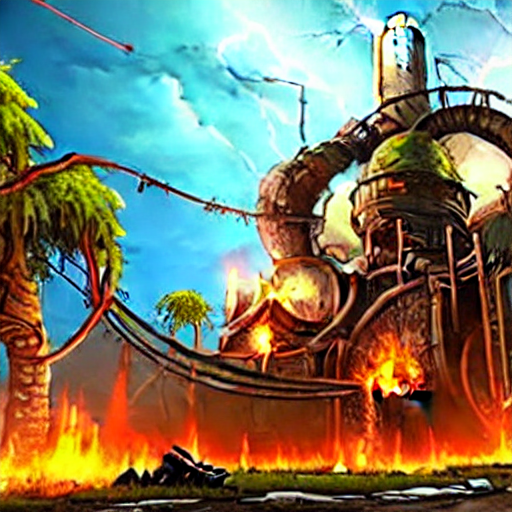

In [9]:
images = images.reshape((images.shape[0],) + images.shape[-3:])
images = pipeline.numpy_to_pil(images)
image_grid(images, 1, 1)

In [10]:
result = []
batch_size_list = [1,1,2,2,4,4,8,8]
for batch_size in batch_size_list:
    try:
        rng = jax.random.PRNGKey(0)
        rng = jax.random.split(rng, num_devices)
        
        _prompt = [prompt] * batch_size
        prompt_ids = pipeline.prepare_inputs(_prompt)

        _neg_prompt = [negative_prompt] * batch_size
        neg_prompt_ids = pipeline.prepare_inputs(_neg_prompt)

        p_params = replicate(params)
        prompt_ids = shard(prompt_ids)

        neg_prompt_ids = shard(neg_prompt_ids)

        # print(prompt_ids.shape)
        # print(neg_prompt_ids.shape)

        t0 = time.time()
        images = pipeline(
            prompt_ids=prompt_ids,
            neg_prompt_ids=neg_prompt_ids,
            num_inference_steps=50,
            guidance_scale=cfg_scale,
            height=512,
            width=512,
            jit=True,
            params=p_params,
            prng_seed=rng,
        )[0]
        t1 = time.time()
        its = steps * batch_size / (t1 - t0)
        print("batch_size {}, it/s: {}, time: {}".format(batch_size, round(its, 2), round((t1 - t0), 2)))
    except Exception:
        print(traceback.print_exc())
        print("batch_size {}, OOM".format(batch_size))
        its = 0
    result.append(round(its, 2))
result_jit = result[1::2]
result_jit

batch_size 1, it/s: 1.52, time: 32.94
batch_size 1, it/s: 9.08, time: 5.51
batch_size 2, it/s: 1.09, time: 91.55
batch_size 2, it/s: 9.19, time: 10.88
batch_size 4, it/s: 1.91, time: 104.85
batch_size 4, it/s: 9.04, time: 22.12
batch_size 8, it/s: 2.98, time: 134.28
batch_size 8, it/s: 9.17, time: 43.62


[1.52, 9.08, 1.09, 9.19, 1.91, 9.04, 2.98, 9.17]